## Import Packages

In [81]:
import pandas as pd
#import numpy as np
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import cross_val_score
#from sklearn.tree import plot_tree
from xgboost import XGBClassifier
import lightgbm as lgb

## Import Data

In [82]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Public URL after making the file public in the format 'https://storage.googleapis.com/...'
train_url = 'https://storage.googleapis.com/home_credit_files/application_train.csv'
test_url = 'https://storage.googleapis.com/home_credit_files/application_test.csv'
POS_CASH_balance_url = 'https://storage.googleapis.com/home_credit_files/POS_CASH_balance.csv'
bureau_url = 'https://storage.googleapis.com/home_credit_files/bureau.csv'
bureau_balance_url = 'https://storage.googleapis.com/home_credit_files/bureau_balance.csv'
credit_card_balance_url = 'https://storage.googleapis.com/home_credit_files/credit_card_balance.csv'
installments_payments_url = 'https://storage.googleapis.com/home_credit_files/installments_payments.csv'
previous_application_url = 'https://storage.googleapis.com/home_credit_files/previous_application.csv'
sample_sub_url = 'https://storage.googleapis.com/home_credit_files/sample_submission.csv'


In [83]:
# Read the CSV directly from the URL
df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)
POS_CASH_balance = pd.read_csv(POS_CASH_balance_url)
bureau = pd.read_csv(bureau_url)
credit_card_balance = pd.read_csv(credit_card_balance_url)
previous_application = pd.read_csv(previous_application_url)


df['is_test'] = 0 
df['is_train'] = 1
test_df['is_test'] = 1
test_df['is_train'] = 0

C:\Users\gbrown\AppData\Local\Temp\ipykernel_2332\3943853959.py:2: DtypeWarning: Columns (90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_url)


In [84]:
installments_payments = pd.read_csv(installments_payments_url)

In [85]:
# target variable
Y = df['TARGET']
train_X = df.drop(['TARGET'], axis = 1)

# test ID
test_id = test_df['SK_ID_CURR']
test_X = test_df

# merge train and test datasets for preprocessing
full_df = pd.concat([train_X, test_X], axis=0)

In [86]:
def _change_objects(df):
    objects = df.select_dtypes(include='object').columns.tolist()
    for col in objects:
        df[col] = df[col].astype('category')
    return df     

# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'category']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 


In [87]:
full_df = _change_objects(full_df)
POS_CASH_balance = _change_objects(POS_CASH_balance)
bureau = _change_objects(bureau)
credit_card_balance = _change_objects(credit_card_balance)
previous_application = _change_objects(previous_application)

# get categorical features
data_cats = _get_categorical_features(full_df)
prev_app_cats = _get_categorical_features(previous_application)
bureau_cats = _get_categorical_features(bureau)
pcb_cats = _get_categorical_features(POS_CASH_balance)
ccbal_cats = _get_categorical_features(credit_card_balance)

# factorize the categorical features from train and test data
data = _factorize_categoricals(full_df, data_cats)
previous_application = _factorize_categoricals(previous_application, prev_app_cats)
bureau = _factorize_categoricals(bureau, bureau_cats)
POS_CASH_balance = _factorize_categoricals(POS_CASH_balance, pcb_cats)
credit_card_balance = _factorize_categoricals(credit_card_balance, ccbal_cats)

# create additional dummy features -
data = _get_dummies(data, data_cats) 
previous_application = _get_dummies(previous_application, prev_app_cats)
bureau = _get_dummies(bureau, bureau_cats)
pcb = _get_dummies(POS_CASH_balance, pcb_cats)
credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)


In [107]:
print(full_df.dtypes.value_counts())

float64    65
int64      58
Name: count, dtype: int64


In [89]:
## More Feature Ideas Reference : https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm 

## count the number of previous applications for a given ID
numeric_cols_prev_app = previous_application.select_dtypes(include=['number']).columns
prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

In [90]:
# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')


In [91]:
## count the number of previous installments
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## Average values for all other variables in installments payments
avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

In [92]:
### count the number of pos cash for a given ID
pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pcb['SK_ID_PREV'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

## Average Values for all other variables in pos cash
pcb_avg = pcb.groupby('SK_ID_CURR').mean()
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')

In [93]:
### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

In [94]:
#### prepare final Train X and Test X dataframes 
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
train_X = data[data['is_train'] == 1][relevant_features]
test_X = data[data['is_test'] == 1][relevant_features]

In [95]:
print(train_X.shape)
print(Y.shape)

(307511, 545)
(307511,)


In [96]:
test_X.dtypes.value_counts()

float64    338
bool       152
int64       55
Name: count, dtype: int64

In [97]:
x_train, x_val, y_train, y_val = train_test_split(train_X, Y, test_size=0.2, random_state=88)
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [104]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 1000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, 
                  lgb_train, 
                  valid_sets=lgb_eval)
                  #early_stopping_rounds=150, 
                  #verbose_eval=200)

c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


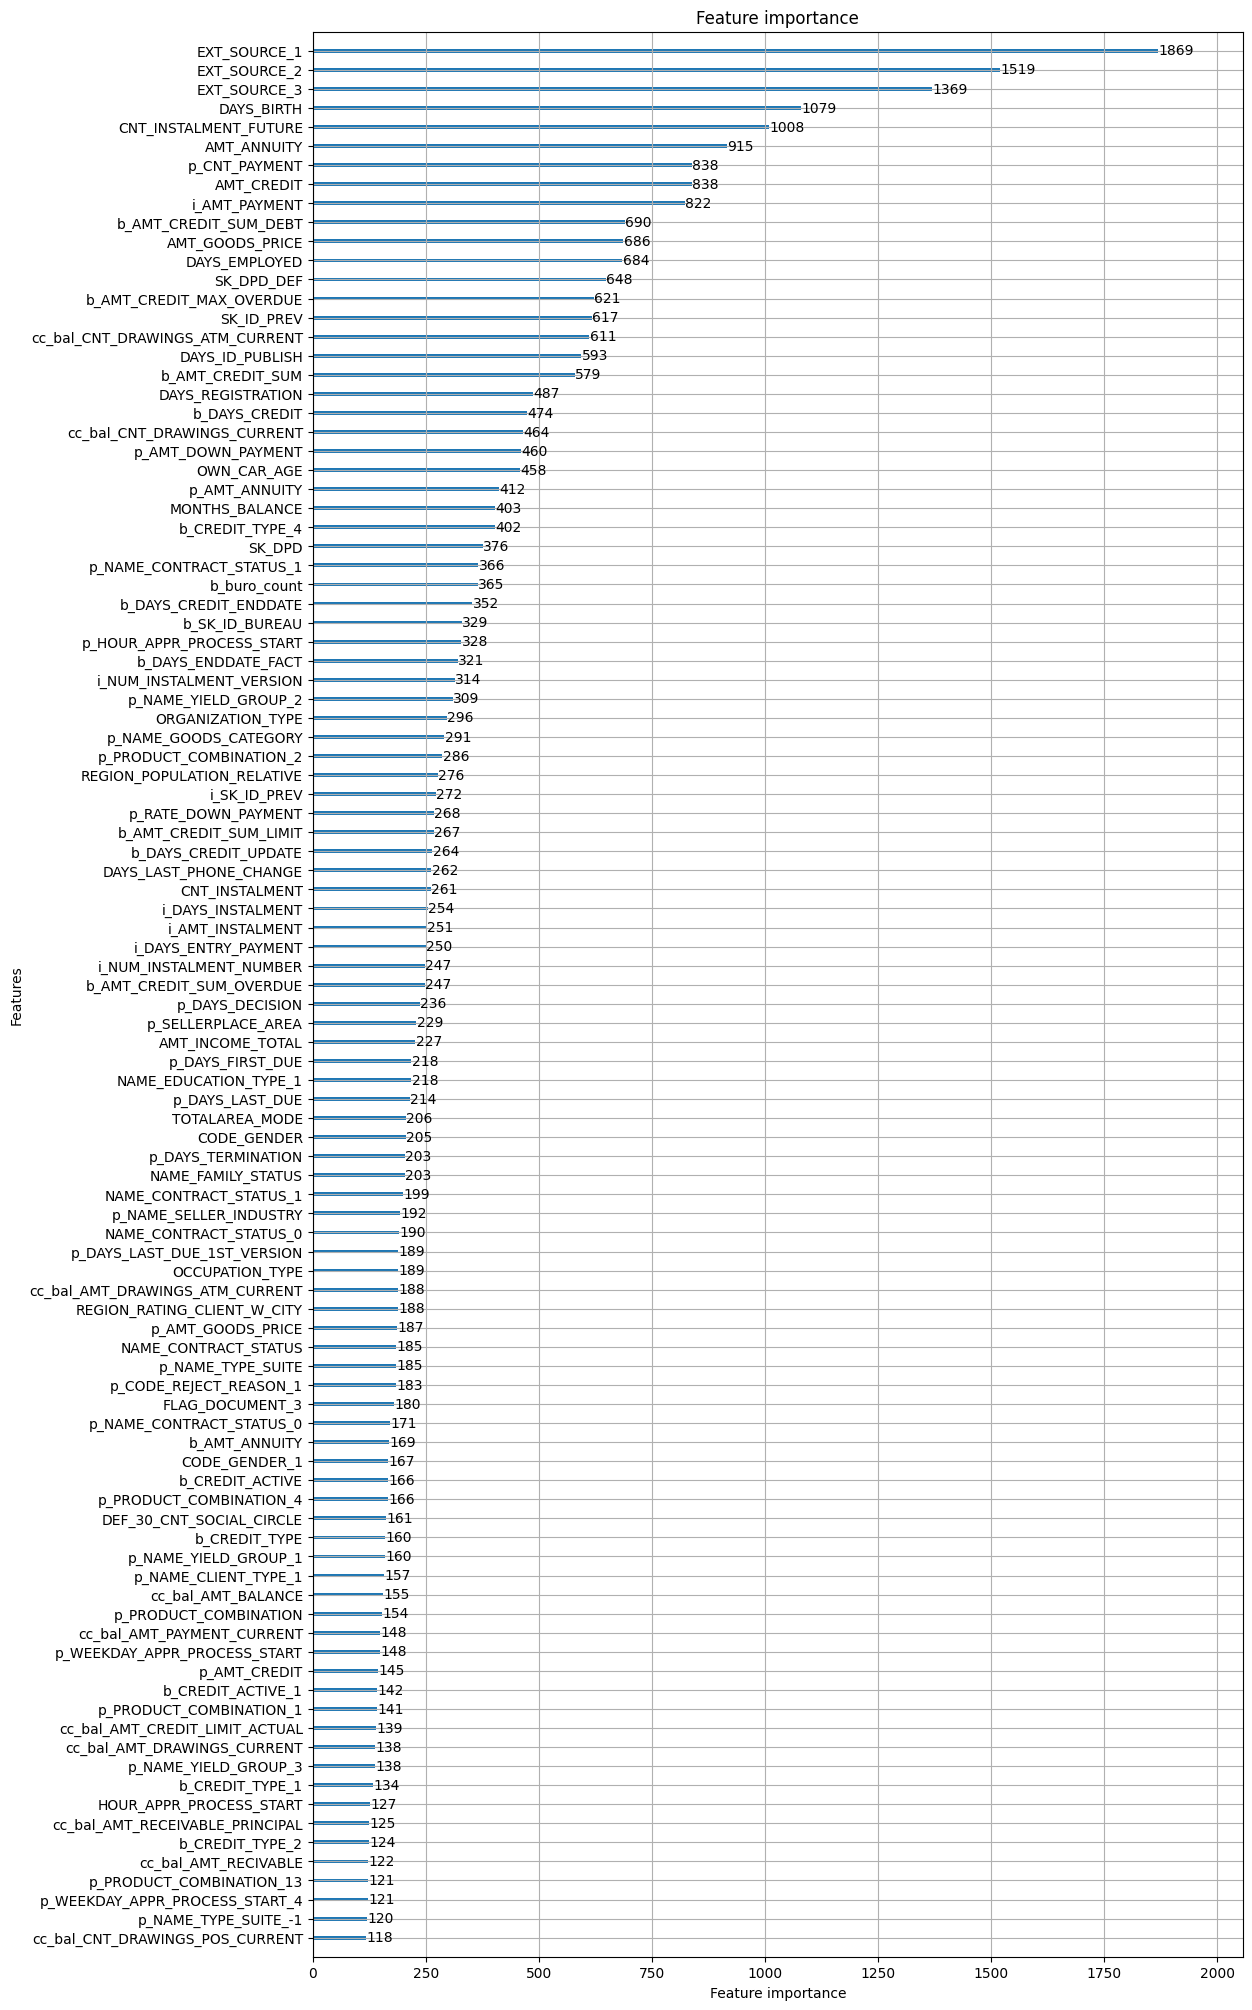

In [105]:
lgb.plot_importance(model, figsize=(12, 25), max_num_features=100);

In [106]:
preds = model.predict(test_X)
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("lgb_baseline.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.049663
1,100005,0.129960
2,100013,0.020558
3,100028,0.043254
4,100038,0.150150
